# Importing Modules

In [22]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup as bs
import requests
import geopy
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
import geopandas as gpd
import json
from progressbar import ProgressBar
from geopy.geocoders import Nominatim
from time import sleep
from descartes import PolygonPatch
import matplotlib.pyplot as plt
%matplotlib inline
from geopy.geocoders import Nominatim
import wget as w
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

conda install -c districtdatalabs yellowbrick

# Loading in CSV file which lists Dublin Towns

In [585]:
Dub = pd.read_csv('Dublintowns.csv', sep=',')
Dub_df = pd.DataFrame(Dub)
plt.savefig('table1.png')
Dub_df.head()

,Town,Area,Address
0,Abbey St,Dublin 1,"Abbey St, Dublin 1, Ireland"
1,Amiens St,Dublin 1,"Amiens St, Dublin 1, Ireland"
2,Capel St,Dublin 1,"Capel St, Dublin 1, Ireland"
3,Henry St,Dublin 1,"Henry St, Dublin 1, Ireland"
4,Mountjoy Sq,Dublin 1,"Mountjoy Sq, Dublin 1, Ireland"


<Figure size 576x396 with 0 Axes>

# Using Nominatim to retrieve the Latitdue and Longitude coordinates of Dublin Towns

In [4]:
address = Dub_df['Address']
geolocator = Nominatim(user_agent="foursquare_agent")


lat = ()
long = ()

for i in range (0,len(address)):
    location = geolocator.geocode(address[i])
    latitude = location.latitude
    longitude = location.longitude
    lat = np.append(lat, latitude)
    long = np.append(long, longitude)
    print(address[i],latitude, longitude)
    sleep(0.3)

Abbey St, Dublin 1, Ireland 53.3485019 -6.2585416
Amiens St, Dublin 1, Ireland 53.3528355 -6.2487534
Capel St, Dublin 1, Ireland 53.3474219 -6.2684092
Henry St, Dublin 1, Ireland 53.3495488 -6.2619787
Mountjoy Sq, Dublin 1, Ireland 53.3566075 -6.25751561135084
North Wall, Dublin 1, Ireland 53.3489554 -6.2396078
O’Connell St, Dublin 1, Ireland 53.3509547 -6.2605881
Parnell Sq, Dublin 1, Ireland 53.3538099 -6.2651306
Talbot St, Dublin 1, Ireland 53.350939 -6.2531516
Ballybough, Dublin 3, Ireland 53.3613503 -6.2461912
Clontarf, Dublin 3, Ireland 53.3608138 -6.1968538
Dollymount, Dublin 3, Ireland 53.3674578 -6.1674246
East Wall, Dublin 3, Ireland 53.3540688 -6.233519
Fairview, Dublin 3, Ireland 53.3628457 -6.2366557
Marino, Dublin 3, Ireland 53.3663095 -6.2347491
Baggot St Upper, Dublin 2, Ireland 53.3329104 -6.2425718
Baggot St Lower, Dublin 2, Ireland 53.3371403 -6.2501609
College Green, Dublin 2, Ireland 53.3442638 -6.2621664
Fitzwilliam Square, Dublin 2, Ireland 53.33538045 -6.2520239

In [5]:
Dub_df['Latitude'] = lat
Dub_df['Longitude'] = long
Dub_df.head()

,Town,Area,Address,Latitude,Longitude
0,Abbey St,Dublin 1,"Abbey St, Dublin 1, Ireland",53.348502,-6.258542
1,Amiens St,Dublin 1,"Amiens St, Dublin 1, Ireland",53.352835,-6.248753
2,Capel St,Dublin 1,"Capel St, Dublin 1, Ireland",53.347422,-6.268409
3,Henry St,Dublin 1,"Henry St, Dublin 1, Ireland",53.349549,-6.261979
4,Mountjoy Sq,Dublin 1,"Mountjoy Sq, Dublin 1, Ireland",53.356608,-6.257516


# Downloading GEOJSON file containing Dublin City data.

In [44]:
url = 'https://raw.githubusercontent.com/AugmentedGeoBae/GeoCluster/master/public/GeoJSON/DublinPostcodes_4326.geojson'
Dublin_geo = w.download(url)

100% [............................................................................] 118713 / 118713

# Visualising the Towns in Dublin and what Postcode they belong to.

In [11]:
dub_lat = 53.3498
dub_lng = -6.2603

map_toronto = folium.Map(location=[dub_lat, dub_lng], zoom_start=11)

map_toronto.choropleth(
    geo_data=Dublin_geo,
    columns=['Area','Cluster Labels'],
    key_on='feature.properties.id',
    fill_color='YlOrRd', 
    fill_opacity=0.1, 
    line_opacity=1,
)



for lat, lng, Address in zip(Dub_df['Latitude'], Dub_df['Longitude'], Dub_df['Address']):
    label = '{}'.format(Address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

C:\Users\lorcan.everard\AppData\Local\Continuum\anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


# Connecting to Foursqaure API

In [507]:
CLIENT_ID = 'A5N2FC1EOC41XDT5FAERSY4AAPQDYK5TNF40QEVZBJKOXSA5'
CLIENT_SECRET = 'O3AWMCBD5PZYKUPKTIQYAQH1N4MK5PSLKFG0LZNU5OAPM0N2' # your Foursquare Secret
VERSION = '20191114'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: A5N2FC1EOC41XDT5FAERSY4AAPQDYK5TNF40QEVZBJKOXSA5
CLIENT_SECRET:O3AWMCBD5PZYKUPKTIQYAQH1N4MK5PSLKFG0LZNU5OAPM0N2


# Scraping Foursquare Data

In [535]:
radius = 700
LIMIT = 200

venues = []

for lat, lng, Address, Area, Town in zip(Dub_df['Latitude'], Dub_df['Longitude'], Dub_df['Address'], Dub_df['Area'], Dub_df['Town']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
       
    for venue in results:
        venues.append((
            Address,
            Area,
            Town,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

# Venues Dataframe

In [582]:
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['Address','Area','Town','AddressLat', 'AddressLong', 'Venue', 'VenueLat', 'VenueLong', 'Category']

print(venues_df.shape)
venues_df.head()

(3988, 9)


,Address,Area,Town,AddressLat,AddressLong,Venue,VenueLat,VenueLong,Category
0,"Abbey St, Dublin 1, Ireland",Dublin 1,Abbey St,53.348502,"[-6.2585416, -6.2487534, -6.2684092, -6.261978...",Offbeat Donut Co,53.347435,-6.255535,Donut Shop
1,"Abbey St, Dublin 1, Ireland",Dublin 1,Abbey St,53.348502,"[-6.2585416, -6.2487534, -6.2684092, -6.261978...",Cassidy's Bar,53.346343,-6.259035,Pub
2,"Abbey St, Dublin 1, Ireland",Dublin 1,Abbey St,53.348502,"[-6.2585416, -6.2487534, -6.2684092, -6.261978...",Vice Coffee Inc.,53.347915,-6.262327,Coffee Shop
3,"Abbey St, Dublin 1, Ireland",Dublin 1,Abbey St,53.348502,"[-6.2585416, -6.2487534, -6.2684092, -6.261978...",Abbey Theatre,53.348542,-6.257492,Theater
4,"Abbey St, Dublin 1, Ireland",Dublin 1,Abbey St,53.348502,"[-6.2585416, -6.2487534, -6.2684092, -6.261978...",Pull&Bear,53.349533,-6.262053,Clothing Store


# One-hot encoding for the venues in each Town

In [587]:
venues_df.groupby(["Address", "Area"]).count()
df_onehot = pd.get_dummies(venues_df[['Category',]], prefix="", prefix_sep="")

df_onehot['Address'] = venues_df['Address']
df_onehot['Area'] = venues_df['Area']

df_onehot = df_onehot.drop(columns=['Pub', 'Bar'])

cols = list(df_onehot)
cols.insert(0, cols.pop(cols.index('Address')))
Dublin_Fdata = df_onehot.ix[:, cols]
Dublin_Fdata.head()

C:\Users\lorcan.everard\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


,Address,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,...,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit,Area
0,"Abbey St, Dublin 1, Ireland",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Dublin 1
1,"Abbey St, Dublin 1, Ireland",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Dublin 1
2,"Abbey St, Dublin 1, Ireland",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Dublin 1
3,"Abbey St, Dublin 1, Ireland",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Dublin 1
4,"Abbey St, Dublin 1, Ireland",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Dublin 1


# Grouping by Postcal Code

In [538]:
Dublin_grouped = df_onehot.groupby('Area').mean().reset_index()
print(Dublin_grouped.shape)
Dublin_grouped.head()

(22, 229)


,Area,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,...,Video Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
0,Dublin 1,0.00122,0.0,0.0,0.003659,0.003659,0.0,0.012195,0.00000,0.0,...,0.0,0.014634,0.000000,0.0,0.0,0.006098,0.000000,0.003659,0.0,0.0
1,Dublin 10,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
2,Dublin 11,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,...,0.0,0.000000,0.021277,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
3,Dublin 12,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.02381,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
4,Dublin 13,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.016393,0.00000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.008197,0.000000,0.0,0.0


# Grouping Venue catagories by top 10 most popular

In [539]:
num_top_venues = 10

for hood in Dublin_grouped['Area']:
    print("----"+hood+"----")
    temp = Dublin_grouped[Dublin_grouped['Area'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Dublin 1----
                venue  freq
0         Coffee Shop  0.08
1                Café  0.07
2               Hotel  0.05
3          Restaurant  0.04
4  Italian Restaurant  0.03
5             Theater  0.02
6           Bookstore  0.02
7      Clothing Store  0.02
8              Bakery  0.02
9    Sushi Restaurant  0.02


----Dublin 10----
                     venue  freq
0          Doctor's Office  0.25
1                     Café  0.25
2            Grocery Store  0.25
3       Chinese Restaurant  0.25
4      American Restaurant  0.00
5                 Pharmacy  0.00
6             Noodle House  0.00
7  North Indian Restaurant  0.00
8                   Office  0.00
9        Outdoor Sculpture  0.00


----Dublin 11----
                  venue  freq
0     Convenience Store  0.09
1  Fast Food Restaurant  0.06
2           Coffee Shop  0.06
3          Tram Station  0.06
4           Supermarket  0.06
5                  Café  0.04
6                  Park  0.04
7         Grocery Store  0.04
8 

In [540]:
Dublin_grouped = df_onehot.groupby('Area').mean().reset_index()
Dublin_grouped1 = Dublin_grouped.drop(columns = ['Area'])
Dublin_grouped1.head()

,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,...,Video Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
0,0.00122,0.0,0.0,0.003659,0.003659,0.0,0.012195,0.00000,0.0,0.0,...,0.0,0.014634,0.000000,0.0,0.0,0.006098,0.000000,0.003659,0.0,0.0
1,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
2,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0,...,0.0,0.000000,0.021277,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
3,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.02381,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
4,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.016393,0.00000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.008197,0.000000,0.0,0.0


# Using Elbow method determine best K value

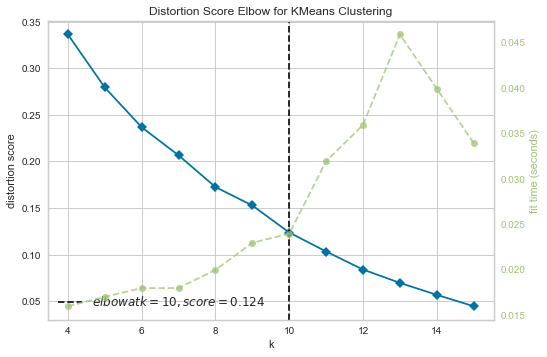

In [551]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,16))

visualizer.fit(Dublin_grouped1)        # Fit the data to the visualizer
visualizer.show()       

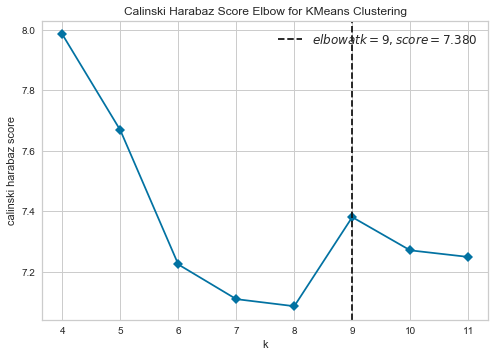

In [575]:
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(4,12), metric='calinski_harabasz', timings=False
)

visualizer.fit(Dublin_grouped1)        # Fit the data to the visualizer
visualizer.show()     

# Clustering the data usuing best value for K

In [589]:
# set number of clusters
kclusters = 9

Dublin_grouped_clustering = Dublin_grouped.drop('Area', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Dublin_grouped_clustering)

# check cluster labels generated for each row in the dataframe
#kmeans.labels_[0:10]
kmeans.labels_

array([4, 1, 5, 5, 8, 4, 4, 6, 0, 4, 4, 3, 0, 2, 4, 4, 7, 4, 0, 4, 4, 0])

In [590]:
Dublin_grouped = df_onehot.groupby('Area').mean().reset_index()
Dublin_grouped1 = Dublin_grouped.drop(columns = ['Area'])
Dublin_grouped1.head()

,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,...,Video Store,Vietnamese Restaurant,Warehouse Store,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo Exhibit
0,0.00122,0.0,0.0,0.003659,0.003659,0.0,0.012195,0.00000,0.0,0.0,...,0.0,0.014634,0.000000,0.0,0.0,0.006098,0.000000,0.003659,0.0,0.0
1,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
2,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0,...,0.0,0.000000,0.021277,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
3,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.02381,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
4,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.016393,0.00000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.008197,0.000000,0.0,0.0


In [591]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# We define a function that sorts into descending order.

In [596]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Area']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

#create a new dataframe
area_venues_sorted = pd.DataFrame(columns=columns)
area_venues_sorted['Area'] = Dublin_grouped['Area']

for ind in np.arange(Dublin_grouped.shape[0]):
    area_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Dublin_grouped.iloc[ind, :], num_top_venues)
  
area_venues_sorted.head()

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Dublin 1,Coffee Shop,Café,Hotel,Restaurant,Italian Restaurant,Clothing Store,Sushi Restaurant,Bakery,Bookstore,Theater
1,Dublin 10,Chinese Restaurant,Café,Doctor's Office,Grocery Store,Zoo Exhibit,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Food & Drink Shop
2,Dublin 11,Convenience Store,Coffee Shop,Supermarket,Tram Station,Fast Food Restaurant,Grocery Store,Café,Park,Gastropub,Electronics Store
3,Dublin 12,Supermarket,Convenience Store,Fast Food Restaurant,Café,Coffee Shop,Tram Station,Department Store,Sporting Goods Shop,Diner,Insurance Office
4,Dublin 13,Seafood Restaurant,Café,Coffee Shop,Harbor / Marina,Ice Cream Shop,Deli / Bodega,Gastropub,Train Station,Grocery Store,Fish & Chips Shop


# New Dataframe with the most common venues for each town from one to ten.

In [597]:
area_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Dublin_merged = Dub_df

#merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Dublin_merged = Dublin_merged.join(area_venues_sorted.set_index('Area'), on='Area')

Dublin_merged.head() # check the last columns!

,Town,Area,Address,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey St,Dublin 1,"Abbey St, Dublin 1, Ireland",4,Coffee Shop,Café,Hotel,Restaurant,Italian Restaurant,Clothing Store,Sushi Restaurant,Bakery,Bookstore,Theater
1,Amiens St,Dublin 1,"Amiens St, Dublin 1, Ireland",4,Coffee Shop,Café,Hotel,Restaurant,Italian Restaurant,Clothing Store,Sushi Restaurant,Bakery,Bookstore,Theater
2,Capel St,Dublin 1,"Capel St, Dublin 1, Ireland",4,Coffee Shop,Café,Hotel,Restaurant,Italian Restaurant,Clothing Store,Sushi Restaurant,Bakery,Bookstore,Theater
3,Henry St,Dublin 1,"Henry St, Dublin 1, Ireland",4,Coffee Shop,Café,Hotel,Restaurant,Italian Restaurant,Clothing Store,Sushi Restaurant,Bakery,Bookstore,Theater
4,Mountjoy Sq,Dublin 1,"Mountjoy Sq, Dublin 1, Ireland",4,Coffee Shop,Café,Hotel,Restaurant,Italian Restaurant,Clothing Store,Sushi Restaurant,Bakery,Bookstore,Theater


# Examining Clusters
#Map of the neighbourhood clusters in Toronto by colour.

In [569]:
map_clusters = folium.Map(location=[53.3198, -6.2603], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

map_clusters.choropleth(
    geo_data=Dublin_geo,
    data=Dublin_merged,
    columns=['Area','Cluster Labels'],
    key_on='feature.properties.id',
    fill_color='YlOrRd', 
    fill_opacity=0.1, 
    line_opacity=1,
)

markers_colors = []
for lat, lon, Area, cluster in zip(Dublin_merged['Latitude'], Dublin_merged['Longitude'], Dublin_merged['Area'], Dublin_merged['Cluster Labels']):
    label = folium.Popup(str(Area) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

C:\Users\lorcan.everard\AppData\Local\Continuum\anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [661]:
clusters1 = Dublin_merged.groupby(['Cluster Labels'])['Town'].apply(','.join).reset_index()
clusters = pd.DataFrame(Dublin_merged.groupby('Cluster Labels', as_index=False).apply(lambda x: ", ".join(x['Town'].tolist())), columns=['Similar'])
clusters1['Count'] = Dublin_merged.groupby('Cluster Labels')['Town'].count()
clusters1 = clusters1[['Cluster Labels','Count','Town']]
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rowwidth', -1)

clusters1

OptionError: "No such keys(s): 'display.max_rowwidth'"

In [629]:
clusters1 = Dublin_merged.groupby(['Cluster Labels'])['Town'].apply(','.join).reset_index()
clusters1.insert(0, cols.pop(cols.index('Cluster')))
clusters1

,Cluster Labels,Town
0,0,"Harold’s Cross,Templeogue,Terenure,Beaumont,Dr..."
1,1,Ballyfermot
2,2,Firhouse
3,3,"Chapelizod,Palmerstown"
4,4,"Abbey St,Amiens St,Capel St,Henry St,Mountjoy ..."
5,5,"Cappagh,Cremore,Dubber,Finglas,Jamestown,Kilsh..."
6,6,"Ballinteer,Ballyboden,Knocklyon,Sandyford"
7,7,"Artane,Harmonstown,Raheny"
8,8,"Baily,Baldoyle,Bayside,Donaghmede,Sutton,Howth"


In [616]:
clusters1['Count'] = clusters['Count']